In [1]:
import os
import time
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from zipfile import ZipFile
import skimage.io
from PIL import Image
import seaborn as sns
from sklearn.manifold import TSNE
import random
import umap
from itertools import product

from mnist_generator import get_mnist_loaders
from mnistm_generator import get_mnistm_loaders
from DANN import *
from DA import *
from test import *
from train import *
from visualize import *
from util import *

# make sure using CPU

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
device

device(type='cuda', index=0)

# mnist dataset

In [4]:
mnist_train_loader,mnist_eval_loader, mnist_test_loader = get_mnist_loaders(batch_size=128)

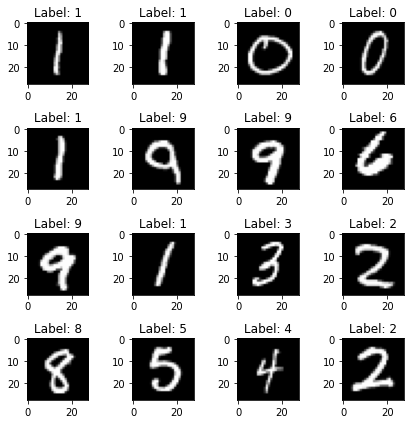

In [5]:

visualize_mnist(mnist_train_loader,4)

# mnistm dataset

In [6]:

mnistm_train_loader, mnistm_eval_loader,mnistm_test_loader = get_mnistm_loaders(batch_size=128)

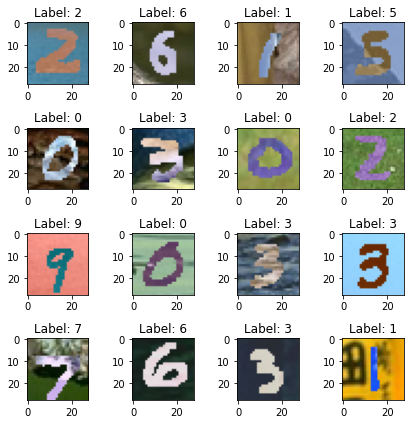

In [7]:
visualize_mnistm(mnistm_train_loader,4)

# visualization of representation of the original datasets

In [8]:
features, labels = generate_domain_datas(mnist_train_loader, mnistm_train_loader)

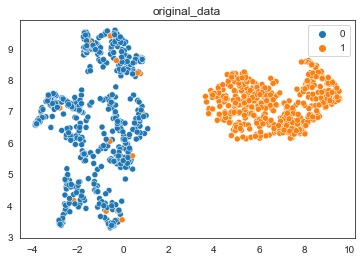

In [9]:
visualize_domain_UMAP(features, labels, name="original_data",size=1000)


# source only

In [8]:
source_accs,dann_source_only = DANNTrain_source_only(mnist_train_loader, 
                                                                    mnist_eval_loader,
                                                                    epochs=300,intervals=30)

30/300: source_acc: 0.9863666666666666
60/300: source_acc: 0.9905166666666667
90/300: source_acc: 0.9923666666666666
120/300: source_acc: 0.9942833333333333
150/300: source_acc: 0.99495
180/300: source_acc: 0.9956833333333334
210/300: source_acc: 0.99605
240/300: source_acc: 0.9964833333333334
270/300: source_acc: 0.9973333333333333
300/300: source_acc: 0.9972333333333333


In [26]:
save_model(dann_source_only,"./models/dann_source_only.pt")

In [12]:
source_acc = DANNAccuracy_source_only(dann_source_only, mnist_test_loader)
print(f'source_acc: {source_acc}')

source_acc: 0.9874


In [11]:
source_acc = DANNAccuracy_source_only(dann_source_only, mnistm_test_loader)
print(f'source_acc: {source_acc}')

source_acc: 0.4741


# target only

In [13]:
target_accs, dann_target_only = DANNTrain_source_only(mnistm_train_loader, mnistm_eval_loader, epochs=300,intervals=30)

30/300: source_acc: 0.9449666666666666
60/300: source_acc: 0.9515
90/300: source_acc: 0.9556333333333333
120/300: source_acc: 0.9564666666666667
150/300: source_acc: 0.9573333333333334
180/300: source_acc: 0.9590333333333333
210/300: source_acc: 0.9575666666666667
240/300: source_acc: 0.9596
270/300: source_acc: 0.9587
300/300: source_acc: 0.9604


In [25]:
save_model(dann_target_only,"./models/dann_target_only.pt")

In [15]:
source_acc = DANNAccuracy_source_only(dann_target_only, mnist_test_loader)
print(f'source_acc: {source_acc}')

source_acc: 0.8403


In [16]:
source_acc = DANNAccuracy_source_only(dann_target_only, mnistm_test_loader)
print(f'source_acc: {source_acc}')

source_acc: 0.9612


# classifier only

In [17]:
source_accs, target_accs, dann_classify_only = DANNTrain_classify_only(mnist_train_loader,mnist_eval_loader,mnistm_train_loader, mnistm_eval_loader, epochs=300,intervals=30)

30/300: source_acc: 0.98465, target_acc 0.9473666666666667
60/300: source_acc: 0.9884833333333334, target_acc 0.9552666666666667
90/300: source_acc: 0.99055, target_acc 0.95635
120/300: source_acc: 0.9921166666666666, target_acc 0.9589
150/300: source_acc: 0.9924666666666667, target_acc 0.95905
180/300: source_acc: 0.9937666666666667, target_acc 0.95835
210/300: source_acc: 0.9936, target_acc 0.96035
240/300: source_acc: 0.9943833333333333, target_acc 0.95975
270/300: source_acc: 0.9946833333333334, target_acc 0.9605833333333333
300/300: source_acc: 0.9946666666666667, target_acc 0.96115


In [24]:
save_model(dann_classify_only,'./models/dann_classify_only.pt')

In [20]:
source_acc, target_acc  = DANNAccuracy_classify_only(dann_classify_only, mnist_test_loader,mnistm_test_loader)
print(f'source_acc: {source_acc}, target_acc {target_acc}')

source_acc: 0.987, target_acc 0.9602


In [12]:
proxy = Proxy_A_distance(np.array(features.cpu()),np.array(labels.cpu()),10)
print(proxy)

1.98608


# build DANN model

In [8]:
source_accs, target_accs, domain_accs, dann = DANNTrain(
      mnist_train_loader,
      mnistm_train_loader,
      mnist_eval_loader,
      mnistm_eval_loader,
      epochs=600,
      intervals = 30)

30/600: source_acc: 0.9703166666666667,target_acc: 0.82055, domain_acc: 0.7135583333333333
60/600: source_acc: 0.9699666666666666,target_acc: 0.8938, domain_acc: 0.6149833333333333
90/600: source_acc: 0.9719,target_acc: 0.9046666666666666, domain_acc: 0.5959166666666667
120/600: source_acc: 0.9764333333333334,target_acc: 0.9085166666666666, domain_acc: 0.579425
150/600: source_acc: 0.9804333333333334,target_acc: 0.9119833333333334, domain_acc: 0.56975
180/600: source_acc: 0.9811166666666666,target_acc: 0.9141333333333334, domain_acc: 0.573325
210/600: source_acc: 0.9827833333333333,target_acc: 0.9171166666666667, domain_acc: 0.5676916666666667
240/600: source_acc: 0.9835666666666667,target_acc: 0.9173166666666667, domain_acc: 0.566375
270/600: source_acc: 0.9865,target_acc: 0.91955, domain_acc: 0.5622666666666667
300/600: source_acc: 0.9853666666666666,target_acc: 0.9221833333333334, domain_acc: 0.557975
330/600: source_acc: 0.9880666666666666,target_acc: 0.9255833333333333, domain_acc

In [13]:
# USE WHEN YOU WANT TO LOAD THE SAVED MODEL
dann = load_DANN("./models/dann_v1.pt")

In [10]:
s_acc, t_acc, domain_acc = DANNAccuracy(dann, mnist_test_loader,mnistm_test_loader)
print(f'source_acc: {s_acc},target_acc: {t_acc}, domain_acc: {domain_acc}')

source_acc: 0.9748,target_acc: 0.9346, domain_acc: 0.55945


In [14]:
features, labels = generate_domain_datas_from_dann(dann, mnist_train_loader,mnistm_train_loader)

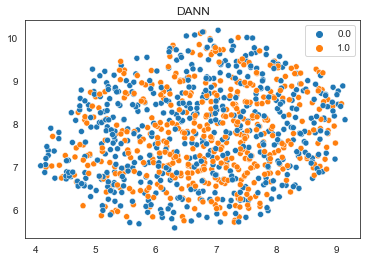

In [15]:
visualize_domain_UMAP(features, labels,name="DANN",size=1000)

In [17]:
proxy = Proxy_A_distance(np.array(features),np.array(labels),10)
print(proxy)

1.7612399995326995


In [9]:
# USE WHEN YOU WANT TO SAVE OR UPDATE THE MODEL
save_model(dann,"./models/dann_v1.pt")

# Denoising Autoencoders

In [15]:
loss_arr, autoencoder = DATrain(mnist_train_loader, mnistm_train_loader, mnist_eval_loader, mnistm_eval_loader,1000,200,intervals=20)

20/200: avg_loss:0.02541697584092617
40/200: avg_loss:0.01601659320294857
60/200: avg_loss:0.014056910760700703
80/200: avg_loss:0.01330516580492258
100/200: avg_loss:0.012922337278723717
120/200: avg_loss:0.012596912682056427
140/200: avg_loss:0.012434118427336216
160/200: avg_loss:0.012265008874237537
180/200: avg_loss:0.012163224630057812
200/200: avg_loss:0.012083367444574833


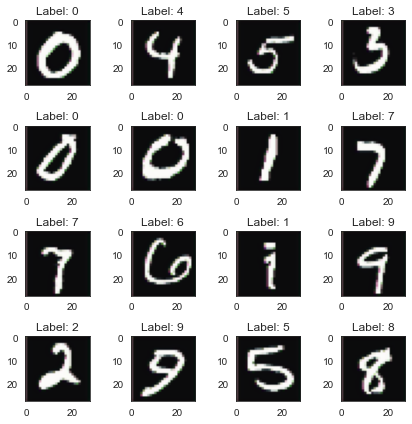

In [16]:
visualize_from_DA(autoencoder,mnist_train_loader,4)

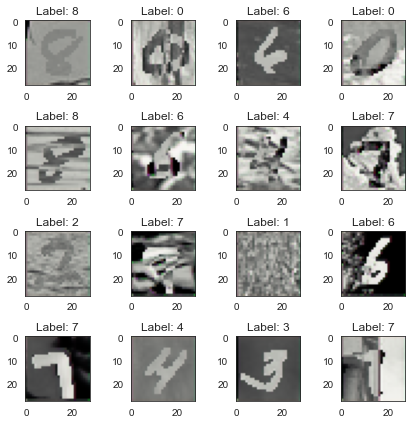

In [17]:
visualize_from_DA(autoencoder,mnistm_train_loader,4)

In [35]:
save_model(autoencoder,"./models/da_v1.pt")

In [18]:
autoencoder = DenoisingAutoencoder(100)
autoencoder = load_DA("./models/da_v1.pt")

In [19]:
features, labels = generate_domain_datas_DA(autoencoder, mnist_train_loader,mnistm_train_loader)

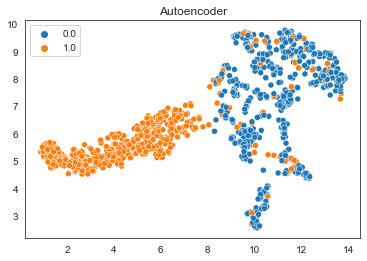

In [20]:
visualize_domain_UMAP(features, labels,name="Autoencoder",size=1000)

In [22]:
proxy = Proxy_A_distance(np.array(features),np.array(labels),10)
print(proxy)

1.9926799999084324


# DANN with encoder from autoencoder

In [41]:
source_accs, target_accs, domain_accs, dann_da=DANNTrain_with_DA(autoencoder, 
                                                                                mnist_train_loader, 
                                                                                mnistm_train_loader, 
                                                                                mnist_eval_loader, 
                                                                                mnistm_eval_loader, 
                                                                                600,30)

30/600: source_acc: 0.9702166666666666,target_acc: 0.8171, domain_acc: 0.7091
60/600: source_acc: 0.9746,target_acc: 0.88135, domain_acc: 0.6411916666666667
90/600: source_acc: 0.9771166666666666,target_acc: 0.8941833333333333, domain_acc: 0.6018333333333333
120/600: source_acc: 0.9781666666666666,target_acc: 0.8995, domain_acc: 0.5806916666666667
150/600: source_acc: 0.9772833333333333,target_acc: 0.9038833333333334, domain_acc: 0.5513833333333333
180/600: source_acc: 0.9813,target_acc: 0.9089833333333334, domain_acc: 0.5612666666666667
210/600: source_acc: 0.9839,target_acc: 0.9133666666666667, domain_acc: 0.5697833333333333
240/600: source_acc: 0.9839333333333333,target_acc: 0.9140166666666667, domain_acc: 0.5595
270/600: source_acc: 0.9868166666666667,target_acc: 0.9153166666666667, domain_acc: 0.567525
300/600: source_acc: 0.9855333333333334,target_acc: 0.91645, domain_acc: 0.55845
330/600: source_acc: 0.9887333333333334,target_acc: 0.9172833333333333, domain_acc: 0.56848333333333

In [42]:
#save_model(dann_da, "./models/dann_da_v1.pt")

In [23]:
def load_DANN_v2(name,isGPU=True):
    dann = DANN_v2()
    if (isGPU):
        dann = dann.to(device)
    dann.load_state_dict(torch.load(name))
    return dann

In [24]:
dann_da = load_DANN_v2("./models/dann_da_v1.pt")

In [43]:
DANNAccuracy_with_DA(dann_da,autoencoder, mnist_test_loader, mnistm_test_loader)

(0.9738, 0.9291, 0.5508)

In [25]:
features, labels = generate_domain_datas_from_extractor_with_DA(dann_da,autoencoder, mnist_train_loader,mnistm_train_loader)

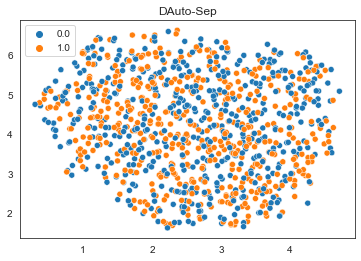

In [26]:
visualize_domain_UMAP(features, labels,name="DAuto-Sep",size=1000)

In [28]:
proxy = Proxy_A_distance(np.array(features),np.array(labels),10)
print(proxy)

1.6453999996185302
